# Quotes
## Sebastian Krauze

In [1]:
from pylab import *
import pickle
import datetime
import gzip

In [2]:
### List of order types: 
### "B" = 1 -- Add buy order
### "S" = 2 -- Add sell order
### "E" = 3 -- Execute outstanding order in part
### "C" = 4 -- Cancel outstanding order in part
### "F" = 5 -- Execute outstanding order in full
### "D" = 6 -- Delete outstanding order in full
### "X" = 7 -- Bulk volume for the cross event
### "T" = 8 -- Execute non-displayed order

In [3]:
tickers=["AAL", "AAPL","ADBE","ADI", "ADP", "ADSK","AKAM","ALXN","AMAT","AMGN",
         "AMZN","ATVI","AVGO","BBBY","BIDU","BIIB","BMRN","CA",  "CELG","CERN",
        "CHKP","CHRW","CHTR","CMCSA","COST","CSCO","CTSH","CTXS","DISCA","DISH",
         "DLTR","EA",  "EBAY","EQIX","ESRX","EXPD","FAST","FB",  "FISV","FOXA",
         "GILD","GOOG","GRMN","HSIC","ILMN","INTC","INTU","ISRG","JD",  "KHC",
         "KLAC","LBTYA","LLTC","LMCA","LRCX","LVNTA","MAR","MAT","MDLZ","MNST",
         "MSFT","MU",  "MYL", "NFLX","NTAP","NVDA","NXPI","ORLY","PAYX","PCAR",
         "PCLN","QCOM","REGN","ROST","SBAC","SBUX","SIRI","SNDK","SPLS","SRCL",
         "STX", "SYMC","TRIP","TSCO","TSLA","TXN", "VIAB","VIP", "VOD", "VRSK",
         "VRTX","WDC", "WFM", "WYNN","XLNX","YHOO"]

days=['07','08','09','10','11']

In [6]:
t0 = datetime.datetime.now()

for ticker in tickers[:1]:
    for day in days[:1]:
        
# -----------------------------------------------------------------------------------------------------------------------
        
        ### Load data
        print(ticker, day)
        
        mytime1 = datetime.datetime.now()
        
        data = genfromtxt(gzip.open('../2016/201603%s_%s.csv.gz' % (day,ticker)), 
                          dtype='str', skip_header = 1, delimiter = ',')
        
        mytime2 = datetime.datetime.now()
        
        print('Loading data:', mytime2 - mytime1)

# -----------------------------------------------------------------------------------------------------------------------        
        
        ### Lists of times, ids etc.
        times_ = array([int(mytime) for mytime in data[:,0]])
        ids_ = array([int(myid) for myid in data[:,2]])
        types_ = array([1 * (mytype == 'B') + 
                        2 * (mytype == 'S') +
                        3 * (mytype == 'E') +
                        4 * (mytype == 'C') +
                        5 * (mytype == 'F') +
                        6 * (mytype == 'D') +
                        7 * (mytype == 'X') +
                        8 * (mytype == 'T') for mytype in data[:,3]])
        volumes_ = array([int(myvolume) for myvolume in data[:,4]])
        prices_ = array([int(myprice) for myprice in data[:,5]])
        
        ids = ids_[types_<7]
        times = times_[types_<7]
        types = types_[types_<7]
        volumes = volumes_[types_<7]
        prices = prices_[types_<7]

# -----------------------------------------------------------------------------------------------------------------------        
        
        ### reference lists
        prices_ref = 1 * prices
        types_ref = 0 * types
        times_ref = 0 * times
        volumes_ref = 0 * types
        index_ref= 0 * types
        newids = {}
        insertnr = {}
        hv = 0
        hv_prices = prices[types < 3]
        hv_types = types[types < 3]
        hv_times = times[types < 3]
        hv_volumes = volumes[types < 3]
        
# -----------------------------------------------------------------------------------------------------------------------
        
        for iii in range(len(ids)):
            if (types[iii] < 3):           ### Insertion
                newids[ids[iii]] = hv
                insertnr[ids[iii]] = iii
                hv += 1
            else: 
                prices_ref[iii] = hv_prices[newids[ids[iii]]]
                types_ref[iii] = hv_types[newids[ids[iii]]]
                times_ref[iii] = hv_times[newids[ids[iii]]]
                index_ref[iii] = insertnr[ids[iii]]
                volumes_ref[iii] = hv_volumes[newids[ids[iii]]]

        mytime3 = datetime.datetime.now()
        print('Making lists:', mytime3 - mytime2)
                     
# -----------------------------------------------------------------------------------------------------------------------
            
        ### minimum and maximum trade price
        minP = round(0.9 * (1. * prices_ref[types == 5] / 10000).min(),2)
        maxP = round(1.1 * (1. * prices_ref[types == 5] / 10000).max(),2)
        valuesP = minP + 0.01 * arange(int((maxP - minP) / 0.01))#arange(minP,maxP,0.01)
        maxP = valuesP.max()
        
# -----------------------------------------------------------------------------------------------------------------------

        ### construct quotes and spread
        nAsk = 0 * valuesP
        nAsk[-1] = 1
        nBid = 0 * valuesP
        nBid[0] = 1
        bestAsk = 10000000.
        bestAskOld = 10000000.
        bestBid = 0.
        bestBidOld = 0.
        bestAsks = []
        bestBids = []
        bestTimes = []
        
# -----------------------------------------------------------------------------------------------------------------------
        
        for iii in range(len(ids)):
            ### Incomming limit orders
            myPriceIndex = int(round(1. * (1.* prices_ref[iii] / 10000 - minP) / 0.01))
            bestAskOld = 1 * bestAsk
            bestBidOld = 1 * bestBid
            if (0 <= myPriceIndex and myPriceIndex < len(valuesP)):
                if types[iii]==2:
                    if (nAsk[myPriceIndex] == 0):
                        bestAsk = min(bestAsk,valuesP[myPriceIndex])
                    nAsk[myPriceIndex] += 1
                if types[iii]==1:
                    if (nBid[myPriceIndex] == 0):
                        bestBid = max(bestBid,valuesP[myPriceIndex])
                    nBid[myPriceIndex] += 1
                ### limit orders completely leaving
                if (types[iii] == 5 or types[iii] == 6):
                    if (types_ref[iii] == 2):
                        nAsk[myPriceIndex] -= 1
                        if (nAsk[myPriceIndex] == 0 and valuesP[myPriceIndex] == bestAsk):
                            bestAsk = valuesP[nAsk > 0].min()
                    else:
                        nBid[myPriceIndex] -= 1
                        if (nBid[myPriceIndex] == 0 and valuesP[myPriceIndex] == bestBid):
                            bestBid = valuesP[nBid > 0].max()
                        
            if (bestAsk != bestAskOld or bestBid != bestBidOld):
                
                bestTimes.append(times[iii])
                bestAsks.append(bestAsk)
                bestBids.append(bestBid)
                bestAskOld = bestAsk
                bestBidOld = bestBid
                
# -----------------------------------------------------------------------------------------------------------------------
        
        spread_ = array(bestAsks) - array(bestBids)
        timesS = array(bestTimes)
        midpoint_ = 1. * (array(bestAsks) + array(bestBids)) / 2
        day_times_ind = (1. * timesS / 3600 / 1000 > 9.5) * (1. * timesS / 3600 / 1000 < 16) > 0
        spread = spread_[day_times_ind]
        midpoint = midpoint_[day_times_ind]
        times_spread = 1. * timesS[day_times_ind] / 3600 / 1000
        pickle.dump((spread,times_spread,midpoint),open('../spread_201603%s_%s.pickl' % (day,ticker), 'wb'))

        mytime4 = datetime.datetime.now()
        print('Constructing spread and midpoint', mytime4 - mytime3)
        #show()
            
t = datetime.datetime.now()

print('Duration: ', t - t0)

AAL 07
Loading data: 0:00:03.079373
Making lists: 0:00:01.535877
Constructing spread and midpoint 0:00:02.502608
Duration:  0:00:07.119211


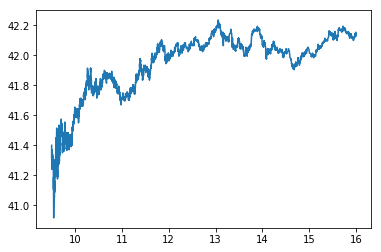

In [7]:
plot(times_spread, midpoint)